In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata


In [3]:
# Functions
# Function for calculating the positions of the atoms
def layer(four_atom_x, four_atom_y, shiftx, shifty, delx1, dely1, delx2, dely2, xcells1, ycells1, xcells2, ycells2, strainy1, strainy2, p, poisson):
    # L1
    layerx1, layery1 = np.array([]), np.array([])
    for i in np.arange(xcells1):
        for j in np.arange(ycells1):
            layerx1 = np.concatenate((layerx1, four_atom_x + i*shiftx))
            layery1 = np.concatenate((layery1, four_atom_y + j*shifty))
    layery1 = dely1 + layery1*(1 + strainy1)
    layerx1 = delx1 + layerx1*(1 - strainy1*poisson)
    layerz1 = np.transpose(np.ones(len(layerx1))*0)
    # L2
    layerx2, layery2 = np.array([]), np.array([])
    for i in np.arange(xcells2):
        for j in np.arange(ycells2):
            layerx2 = np.concatenate((layerx2, four_atom_x + i*shiftx))
            layery2 = np.concatenate((layery2, four_atom_y + j*shifty))
    layery2 = dely2 + layery2*(1 + strainy2)
    layerx2 = delx2 + layerx2*(1 - strainy2*poisson)
    layerz2 = np.transpose(np.ones(len(layerx2))*p)
    # Concatenate L1 & L2
    layerx = np.concatenate((layerx1, layerx2))
    layery = np.concatenate((layery1, layery2))
    layerz = np.concatenate((layerz1, layerz2))
    return layerx, layery, layerz

def map_stacking3(coords_all, L1SA, L1SB, L2SA, L2SB, ptsx, ptsy, cutoff):
    tree1A = cKDTree(coords_all[L1SA])
    tree1B = cKDTree(coords_all[L1SB])
    tree2A = cKDTree(coords_all[L2SA])
    tree2B = cKDTree(coords_all[L2SB])
    dAA = tree1A.sparse_distance_matrix(tree2A, max_distance = cutoff)
    dAB = tree1A.sparse_distance_matrix(tree2B, max_distance = cutoff)
    dBA = tree1B.sparse_distance_matrix(tree2A, max_distance = cutoff)
    dBB = tree1B.sparse_distance_matrix(tree2B, max_distance = cutoff)   
    lAA = tree1A.query_ball_tree(tree2A, r = cutoff)
    lAB = tree1A.query_ball_tree(tree2B, r = cutoff)
    lBA = tree1B.query_ball_tree(tree2A, r = cutoff)
    lBB = tree1B.query_ball_tree(tree2B, r = cutoff)
    AAmin, ABmin = [], []
    BAmin, BBmin = [], []
    for i, l in enumerate(lAA):
        AAmin.append(dAA[i, l].toarray().min())
    for i, l in enumerate(lAB):
        ABmin.append(dAB[i, l].toarray().min())
    for i, l in enumerate(lBA):
        BAmin.append(dBA[i, l].toarray().min())
    for i, l in enumerate(lBB):
        BBmin.append(dBB[i, l].toarray().min())
    AAmin = np.array(AAmin)*np.sqrt(3)/alat
    ABmin = np.array(ABmin)*np.sqrt(3)/alat
    BAmin = np.array(BAmin)*np.sqrt(3)/alat
    BBmin = np.array(BBmin)*np.sqrt(3)/alat
    xgrid = np.linspace(coords_all[L1SA, 0].min(), coords_all[L1SA, 0].max(), ptsx)
    ygrid = np.linspace(coords_all[L1SA, 1].min(), coords_all[L1SA, 1].max(), ptsy)
    xgrid, ygrid = np.meshgrid(xgrid, ygrid)
    AAg = griddata((coords_all[L1SA, 0], coords_all[L1SA, 1]), AAmin, (xgrid, ygrid), method = 'linear')
    ABg = griddata((coords_all[L1SA, 0], coords_all[L1SA, 1]), ABmin, (xgrid, ygrid), method = 'linear')
    BAg = griddata((coords_all[L1SA, 0], coords_all[L1SA, 1]), BAmin, (xgrid, ygrid), method = 'linear')
    BBg = griddata((coords_all[L1SA, 0], coords_all[L1SA, 1]), BBmin, (xgrid, ygrid), method = 'linear')
    stacking = (BAg - ABg)*(AAg + BBg)/2
    return xgrid, ygrid, stacking


200596


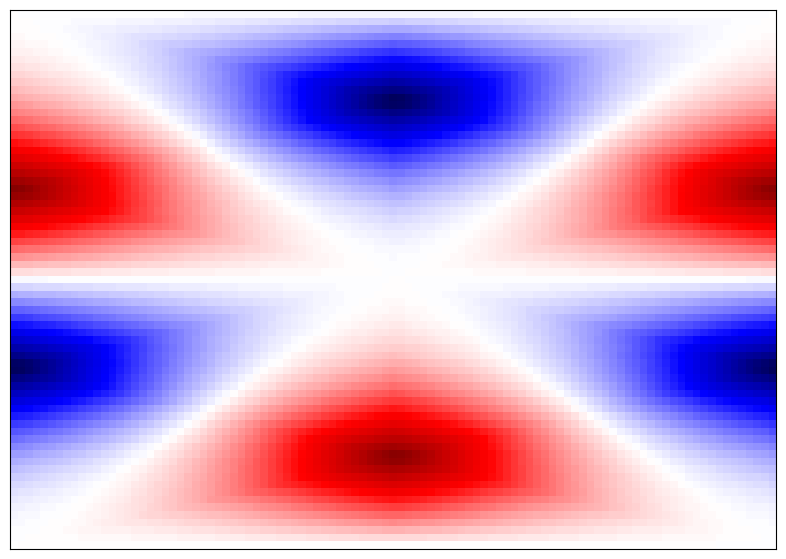

In [13]:
# General parameters
alat = 2.46 # Used when drawing bands
thop = -2.7 # In-plane hopping term
sigma = 0.48 # For hopping terms
d = 3.35 # Interlayer distance
acc = 1/np.sqrt(3) # Carbon-carbon (e.g. nearest neighbour) distance
dd = acc*alat + 0.4
eta = 0.001 # Parameter for DOS calculation, delta function
epsilon = 0.00000001
poisson = 0.4 # Poisson ratio
strainy1 = 0.01 # Strain on the bottom layer along x and y direction
strainy2 = 0 # Strain on the top layer along x and y direction
shiftx, shifty = alat, 3*acc*alat
four_atom_x = np.array([0, -0.5, -0.5, 0])*alat
four_atom_y = np.array([0, 0.5*acc, 1.5*acc, 2*acc])*alat
xdim1, ydim1 = 250, 100 # Number of cells along x and y direction for L1
xdim2, ydim2 = 249, 101 # Number of cells along x and y direction for L2
shiftxx, shiftyy = xdim1*shiftx*(1-poisson*strainy1), ydim1*shifty*(1+strainy1)
delx1, dely1, delx2, dely2 = 0, 0, 0, 0 # AA stacking
# Coords
layerx, layery, layerz = layer(four_atom_x, four_atom_y, shiftx, shifty, delx1, dely1, delx2, dely2, xdim1, ydim1, xdim2, ydim2, strainy1, strainy2, d, poisson)
coords_dev = np.array((layerx, layery)).T
print(len(coords_dev))
L1 = np.where(layerz == 0.0)[0]
L2 = np.where(layerz != 0.0)[0]
L1SA = L1[::2]
L1SB = L1[1::2]
L2SA = L2[::2]
L2SB = L2[1::2]
xgd = 101
ygd = 71
xgrid, ygrid, stacking = map_stacking3(coords_dev, L1SA, L1SB, L2SA, L2SB, xgd, ygd, dd*alat)

# Plot
fig, ax = plt.subplots(1,1, figsize=(10, 7))
plt.pcolormesh(xgrid, ygrid, stacking, shading = 'auto', cmap='seismic', vmin = -1, vmax = 1)#, vmin=-1, vmax=1)
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.savefig('01str_2d_04.png', bbox_inches = 'tight', dpi = 300)
plt.show()
